In [10]:
#import packages, modules, and set environments
import rasterio
from rasterstats import point_query
import os
import pandas as pd
import sys
import geopandas as gpd
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from rasterio.plot import show
import folium
from folium import raster_layers 

#Set base path relative to system
path = sys.path[0]

In [2]:
#IMPORT RASTERS
#Create empty dictionary and import rasters into dictionary. Parse user-defined folder containing the input rasters (must be TIFF).
#Note: Rasters must be same size and projection.  
#If filytype is equal to TIFF, generate key based on first 2 characters of file, open file, assing file in open mode as key value. Count the number of input rasters. 
inRasters = {}

#Change path if using your own folder
rastdir = os.listdir(path + '\Rasters3')
subpath = path + '\Rasters3/'

#create dictionary of input rasters
c = 0
for r in rastdir:
    if r[-3:] == 'tif':
        key = r[:2]
        rast = rasterio.open(subpath + r) 
        inRasters[key] = rast
        c += 1



In [3]:
#Read in validation/training data
#Note: Points must be in same prjection as input rasters
#Specify filename, change path if using your own folder
data = gpd.read_file(path + '\Validation_Data/Val_proj2.shp')


In [4]:
#EXTRACT RASTER VALUES
#for each raster in directory, extract raster values to validation points.
# Name column in geodataframe based on raster file name 
for r in rastdir:
    if r[-3:] == 'tif':
        data[r[:2]] = point_query(data, subpath + r)

In [5]:
#drop nulls
data_clean = data.dropna()

In [6]:
#Split data into k-folds 
#Append to dictionaries to store fold pairs



train_indexes = {}
test_indexes = {}

s = 0
kf = ShuffleSplit(n_splits=10, test_size=3500, train_size=750)
for train_index, test_index in kf.split(data_clean):
    trainkey = 'train' + str(s)
    train = train_index
    train_indexes[trainkey] = train
    testkey = 'test' + str(s)
    test = test_index
    test_indexes[testkey] = test
    s += 1
     


In [7]:
#Join data to train indicies to create training folds
#Use the same dictionary piping system as before (i.e. each training subset gets assigned to key in new dict.)
train_sets = {}

t = 0
for key in train_indexes:
    jtrainkey = 'train' + str(t)
    jtrain = data_clean.iloc[train_indexes[key]]
    train_sets[jtrainkey] = jtrain
    t += 1

In [8]:
#Run FBCR and MCDA for each training fold
#Split train data into dependent and explanatory variables
#Build Random Forest on test data, return variable importance scores
#Use ravel to convert training featured to 1D array
#Run MCDA
#Read raster values as array, multiply by forest importance, append to dictionary
#Sum up weighted arrays
#Write WLC to raster, Base args off input raster
#Extract WLC values to points, join to testing indices to create test folds for input into GWR
#Output test folds as point shapefile


rast = rasterio.open(subpath + 'prox.tif')

a = 0
for key, id in zip(train_sets, test_indexes):
    Bands = {}
    #Specify dependent variable name
    dvar = train_sets[key][['med_U_PPM']].copy()
    
    ivars = train_sets[key].iloc[: , -c:].copy()
    clf = RandomForestRegressor(n_estimators=1000)
    model = clf.fit(ivars,dvar.values.ravel())
    feature_names = list(ivars)
    importances = model.feature_importances_
    forest_importances = pd.Series(importances, index=feature_names)
    for r, i in zip(inRasters, forest_importances):
        bkey = r
        band = inRasters[r].read(1) * i
        band = band 
        Bands[bkey] = band
    wlc = sum(Bands.values())
    wlc_clean = np.where(wlc < 0, 0, wlc)
    transform = rast.transform
    #Write prediction surfaces to new raster. Base args off input raster.
    #Specify path if you want to use a differnt output destination.
    wlc_rast = rasterio.open('WLCs/' + str(key) + '.tif', 'w', driver = 'GTiff', height = wlc_clean.shape[0],
                            width = wlc_clean.shape[1], count = 1, dtype = wlc_clean.dtype, crs = rast.crs,
                            transform = transform)
    wlc_rast.write(wlc_clean,1)
    wlc_rast.close()
    data['wlc'] = point_query(data, 'WLCs/' + str(key) + '.tif')
    data_clean_wlc = data.dropna()
    #Output test points as shapefile.
    #Specify path if you want to use a differnt output destination.
    jtest = data_clean_wlc.iloc[test_indexes[id]]
    jtest.to_file('Testsets/' + 'test' + str(a) + '.shp')
    
    a += 1




c:\ProgramData\Anaconda3\envs\Final3a\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
c:\ProgramData\Anaconda3\envs\Final3a\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
c:\ProgramData\Anaconda3\envs\Final3a\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
c:\ProgramData\Anaconda3\envs\Final3a\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
c:\ProgramData\Anaconda3\envs\Final3a\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.war

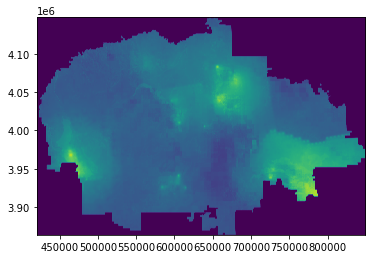

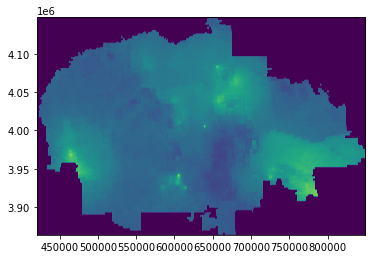

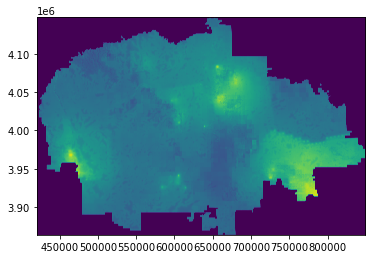

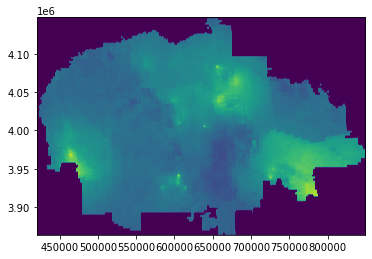

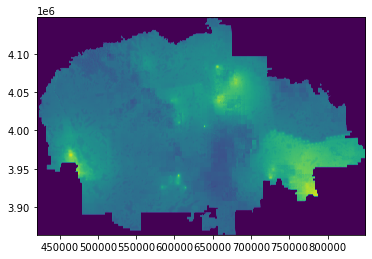

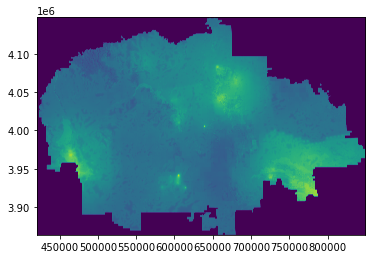

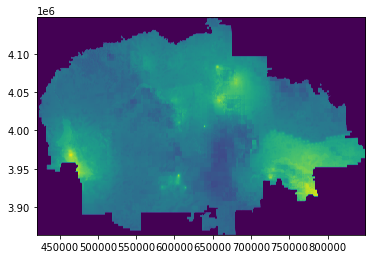

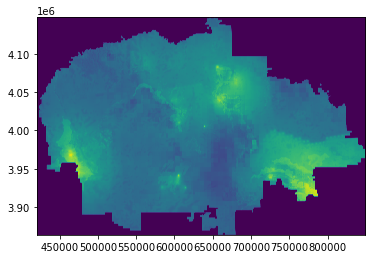

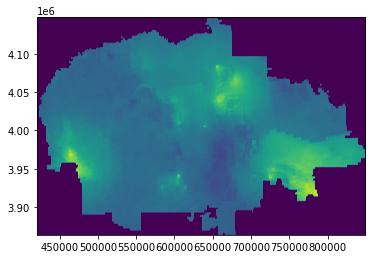

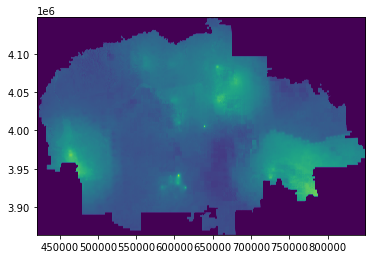

In [9]:
#View output prediction surfaces

exposures = os.listdir(path + '\WLCs')
subpath1 = path + '\WLCs/'

for r in exposures:
    if r[-3:] == 'tif':
        rast = rasterio.open(subpath1 + r)
        show(rast)

In [11]:
#Interactive map
#Open raster (sample used here, user can specify which fold they desire by changing filename/path). Note: Raster must be in WGS 84 for folium.
#Get bounds of raster, create bounding box for folium
#Convert null values to number

pred_ex = rasterio.open('OutFold1.tif')
bounds = pred_ex.bounds
bounds = [[bounds[1], bounds[0]], [bounds[3], bounds[2]]]
pred_ex = np.nan_to_num(pred_ex.read(1), pred_ex.read(1).min() - 100)

In [12]:
#Interactive map
#Plot using folium. Use coordinates of Bluegap/Tachee on Navajo for initilization (user can change for their study area)

m = folium.Map(location=[36.1713, -109.9452], zoom_start=10)
m.add_child(raster_layers.ImageOverlay(image = pred_ex, bounds = bounds, mercator_project= True))
m